<a href="https://colab.research.google.com/github/aimbsg/EVA4_S10/blob/master/EVA4_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)

Implement LR Finder (for SGD, not for ADAM). Use this repo: https://github.com/davidtvs/pytorch-lr-finder (Links to an external site.)

Move LR Finder code to your modules

Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau (Links to an external site.)

Find best LR to train your model

Use SGD with Momentum

Train for 50 Epochs. 

Show Training and Test Accuracy curves

Target 88% Accuracy.

Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
my_path = '/content/gdrive/My Drive/EVA4S10_CIFAR10'
sys.path.append(my_path)

In [4]:
%cd '/content/gdrive/My Drive/EVA4S10_CIFAR10/'
!pwd

/content/gdrive/My Drive/EVA4S10_CIFAR10
/content/gdrive/My Drive/EVA4S10_CIFAR10


In [0]:
%matplotlib inline
import torch
import data_loader as train_test_loader
import visualize_images as show_images
import backbone as model
import train_test
import model_evaluator as evaluate
from transforms_albumentation import AlbumentationTransforms
from gradcam import GradCAM,visualize_cam

In [0]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1) 
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [7]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


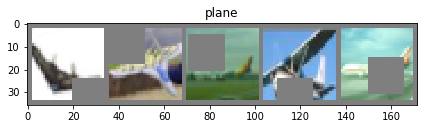

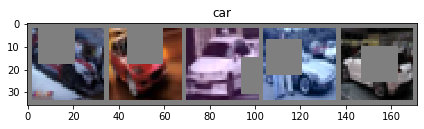

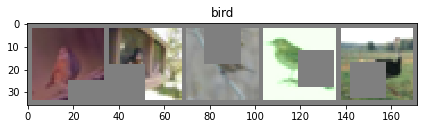

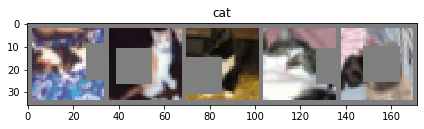

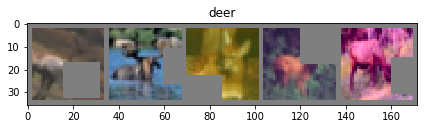

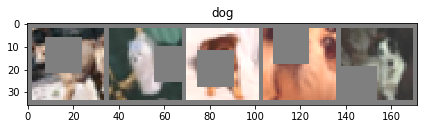

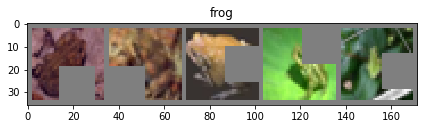

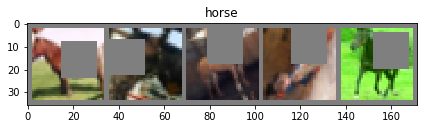

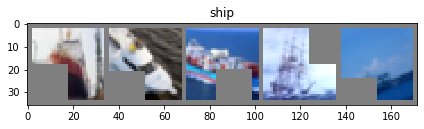

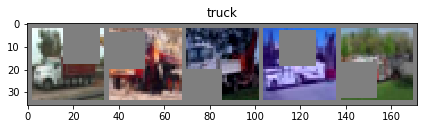

In [7]:
show_images.show_train_data(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18(dropout=0.1).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

LR Finder

https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

In [0]:
#@title LR finder package installer
!pip install torch-lr-finder -v --global-option="amp"

In [0]:
import torch_lr_finder as lr

In [12]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0005)
lr_finder = lr.LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=500 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


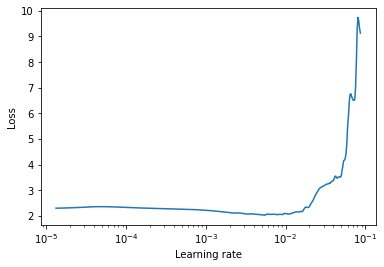

In [13]:
lr_finder.plot()

In [30]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
ideal_lr

0.010630957344480193

In [0]:
lr_finder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0001, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, patience = 2)

# from torch.optim.lr_scheduler import StepLR , MultiStepLR
# optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,weight_decay=0.0005)
# scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

In [11]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []
epochs = 50
best_acc = 85 # save the model only if the accuracy crosses 85% as we already achieved 88% in previous assignment without LR finder

for epoch in range(epochs):
     print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(model, device, trainloader, optimizer, criterion, epoch)     
    #  scheduler.step()
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     train_loss , train_acc = train_test.train_metrics_accumulator(model, device, criterion, trainloader)
     scheduler.step(test_acc[-1])
    
     if(test_acc[-1]>best_acc):
       print("...BEST MODEL...")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/EVA4S10_CIFAR10/bestmodel_50epochs.pt")
       print("Save success...")

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 1 LR: 0.010630957344480193


Loss=1.6333513259887695 Batch_id=390 Accuracy=33.54: 100%|██████████| 391/391 [00:58<00:00,  6.67it/s]



Test set: Average loss: 0.0111, Accuracy: 4895/10000 (48.95%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2 LR: 0.010630957344480193


Loss=1.2602064609527588 Batch_id=390 Accuracy=48.53: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]



Test set: Average loss: 0.0096, Accuracy: 5587/10000 (55.87%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3 LR: 0.010630957344480193


Loss=1.365325689315796 Batch_id=390 Accuracy=56.23: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]



Test set: Average loss: 0.0109, Accuracy: 5521/10000 (55.21%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4 LR: 0.010630957344480193


Loss=1.0864644050598145 Batch_id=390 Accuracy=60.89: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]



Test set: Average loss: 0.0072, Accuracy: 6832/10000 (68.32%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 5 LR: 0.010630957344480193


Loss=0.7750328183174133 Batch_id=390 Accuracy=63.86: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]



Test set: Average loss: 0.0064, Accuracy: 7296/10000 (72.96%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 6 LR: 0.010630957344480193


Loss=1.003014326095581 Batch_id=390 Accuracy=66.30: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]



Test set: Average loss: 0.0059, Accuracy: 7422/10000 (74.22%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 7 LR: 0.010630957344480193


Loss=0.8714321851730347 Batch_id=390 Accuracy=68.00: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]



Test set: Average loss: 0.0059, Accuracy: 7470/10000 (74.70%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 8 LR: 0.010630957344480193


Loss=0.9231497049331665 Batch_id=390 Accuracy=69.73: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]



Test set: Average loss: 0.0057, Accuracy: 7546/10000 (75.46%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 9 LR: 0.010630957344480193


Loss=0.9017928838729858 Batch_id=390 Accuracy=71.20: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]



Test set: Average loss: 0.0050, Accuracy: 7851/10000 (78.51%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 10 LR: 0.010630957344480193


Loss=0.7262738943099976 Batch_id=390 Accuracy=71.79: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0050, Accuracy: 7885/10000 (78.85%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 11 LR: 0.010630957344480193


Loss=0.6558537483215332 Batch_id=390 Accuracy=73.24: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]



Test set: Average loss: 0.0052, Accuracy: 7806/10000 (78.06%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 12 LR: 0.010630957344480193


Loss=0.6668738126754761 Batch_id=390 Accuracy=73.99: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]



Test set: Average loss: 0.0049, Accuracy: 7933/10000 (79.33%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 13 LR: 0.0010630957344480193


Loss=0.6603714823722839 Batch_id=390 Accuracy=77.49: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0036, Accuracy: 8458/10000 (84.58%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 14 LR: 0.0010630957344480193


Loss=0.7409808039665222 Batch_id=390 Accuracy=78.56: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0035, Accuracy: 8538/10000 (85.38%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 15 LR: 0.0010630957344480193


Loss=0.5571249127388 Batch_id=390 Accuracy=79.07: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]



Test set: Average loss: 0.0034, Accuracy: 8524/10000 (85.24%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 16 LR: 0.0010630957344480193


Loss=0.5493437647819519 Batch_id=390 Accuracy=79.12: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]



Test set: Average loss: 0.0034, Accuracy: 8540/10000 (85.40%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 17 LR: 0.0010630957344480193


Loss=0.6824894547462463 Batch_id=390 Accuracy=79.30: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]



Test set: Average loss: 0.0034, Accuracy: 8563/10000 (85.63%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 18 LR: 0.0010630957344480193


Loss=0.6722900867462158 Batch_id=390 Accuracy=79.47: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0032, Accuracy: 8598/10000 (85.98%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 19 LR: 0.0010630957344480193


Loss=0.6658617258071899 Batch_id=390 Accuracy=79.75: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]



Test set: Average loss: 0.0033, Accuracy: 8603/10000 (86.03%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 20 LR: 0.0010630957344480193


Loss=0.5837944746017456 Batch_id=390 Accuracy=79.94: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]



Test set: Average loss: 0.0033, Accuracy: 8609/10000 (86.09%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 21 LR: 0.0010630957344480193


Loss=0.49700602889060974 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0032, Accuracy: 8587/10000 (85.87%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 22 LR: 0.0010630957344480193


Loss=0.4722093939781189 Batch_id=390 Accuracy=80.50: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0032, Accuracy: 8662/10000 (86.62%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 23 LR: 0.0010630957344480193


Loss=0.716572642326355 Batch_id=390 Accuracy=80.74: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]



Test set: Average loss: 0.0032, Accuracy: 8618/10000 (86.18%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 24 LR: 0.0010630957344480193


Loss=0.6908092498779297 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]



Test set: Average loss: 0.0031, Accuracy: 8619/10000 (86.19%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 25 LR: 0.00010630957344480194


Loss=0.4986654222011566 Batch_id=390 Accuracy=81.31: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]



Test set: Average loss: 0.0031, Accuracy: 8656/10000 (86.56%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 26 LR: 0.00010630957344480194


Loss=0.34065836668014526 Batch_id=390 Accuracy=81.08: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]



Test set: Average loss: 0.0031, Accuracy: 8644/10000 (86.44%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 27 LR: 0.00010630957344480194


Loss=0.5714807510375977 Batch_id=390 Accuracy=81.31: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]



Test set: Average loss: 0.0032, Accuracy: 8683/10000 (86.83%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 28 LR: 0.00010630957344480194


Loss=0.5982452630996704 Batch_id=390 Accuracy=81.38: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]



Test set: Average loss: 0.0032, Accuracy: 8674/10000 (86.74%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 29 LR: 0.00010630957344480194


Loss=0.7058103680610657 Batch_id=390 Accuracy=81.27: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]



Test set: Average loss: 0.0032, Accuracy: 8663/10000 (86.63%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 30 LR: 0.00010630957344480194


Loss=0.408958375453949 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]



Test set: Average loss: 0.0031, Accuracy: 8680/10000 (86.80%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 31 LR: 0.00010630957344480194


Loss=0.6100272536277771 Batch_id=390 Accuracy=81.25: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]



Test set: Average loss: 0.0031, Accuracy: 8669/10000 (86.69%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 32 LR: 0.00010630957344480194


Loss=0.5527905225753784 Batch_id=390 Accuracy=81.46: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]



Test set: Average loss: 0.0031, Accuracy: 8694/10000 (86.94%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 33 LR: 0.00010630957344480194


Loss=0.474545419216156 Batch_id=390 Accuracy=81.41: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]



Test set: Average loss: 0.0031, Accuracy: 8668/10000 (86.68%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 34 LR: 0.00010630957344480194


Loss=0.41273054480552673 Batch_id=390 Accuracy=81.27: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]



Test set: Average loss: 0.0031, Accuracy: 8677/10000 (86.77%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 35 LR: 0.00010630957344480194


Loss=0.43241459131240845 Batch_id=390 Accuracy=81.60: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]



Test set: Average loss: 0.0031, Accuracy: 8683/10000 (86.83%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 36 LR: 0.00010630957344480194


Loss=0.5909323692321777 Batch_id=390 Accuracy=81.40: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0031, Accuracy: 8640/10000 (86.40%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 37 LR: 1.0630957344480195e-05


Loss=0.3114370107650757 Batch_id=390 Accuracy=81.36: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.0031, Accuracy: 8692/10000 (86.92%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 38 LR: 1.0630957344480195e-05


Loss=0.5752708911895752 Batch_id=390 Accuracy=81.64: 100%|██████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.0031, Accuracy: 8672/10000 (86.72%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 39 LR: 1.0630957344480195e-05


Loss=0.6430598497390747 Batch_id=390 Accuracy=81.86: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]



Test set: Average loss: 0.0031, Accuracy: 8681/10000 (86.81%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 40 LR: 1.0630957344480195e-05


Loss=0.6477696895599365 Batch_id=390 Accuracy=81.67: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]



Test set: Average loss: 0.0031, Accuracy: 8680/10000 (86.80%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 41 LR: 1.0630957344480195e-05


Loss=0.6925718188285828 Batch_id=390 Accuracy=81.54: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]



Test set: Average loss: 0.0030, Accuracy: 8675/10000 (86.75%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 42 LR: 1.0630957344480195e-05


Loss=0.42825523018836975 Batch_id=390 Accuracy=81.36: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]



Test set: Average loss: 0.0030, Accuracy: 8705/10000 (87.05%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 43 LR: 1.0630957344480195e-05


Loss=0.6045233607292175 Batch_id=390 Accuracy=81.67: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]



Test set: Average loss: 0.0031, Accuracy: 8687/10000 (86.87%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 44 LR: 1.0630957344480195e-05


Loss=0.4914959967136383 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]



Test set: Average loss: 0.0031, Accuracy: 8701/10000 (87.01%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 45 LR: 1.0630957344480195e-05


Loss=0.6044712662696838 Batch_id=390 Accuracy=81.78: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]



Test set: Average loss: 0.0031, Accuracy: 8684/10000 (86.84%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 46 LR: 1.0630957344480195e-05


Loss=0.488752543926239 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.0031, Accuracy: 8680/10000 (86.80%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 47 LR: 1.0630957344480195e-05


Loss=0.5491825938224792 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]



Test set: Average loss: 0.0031, Accuracy: 8692/10000 (86.92%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 48 LR: 1.0630957344480195e-05


Loss=0.42383068799972534 Batch_id=390 Accuracy=81.52: 100%|██████████| 391/391 [01:01<00:00,  6.39it/s]



Test set: Average loss: 0.0031, Accuracy: 8674/10000 (86.74%)



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 49 LR: 1.0630957344480195e-06


Loss=0.624465823173523 Batch_id=390 Accuracy=81.67: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]



Test set: Average loss: 0.0031, Accuracy: 8714/10000 (87.14%)

...BEST MODEL...


  0%|          | 0/391 [00:00<?, ?it/s]

Save success...
Epoch: 50 LR: 1.0630957344480195e-06


Loss=0.5067976117134094 Batch_id=390 Accuracy=81.44: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]



Test set: Average loss: 0.0031, Accuracy: 8704/10000 (87.04%)



In [12]:
evaluate.val_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 86.68 %


In [13]:
evaluate.class_accuracy(model, device, classes, testloader)

Accuracy of plane : 90 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 72 %
Accuracy of  deer : 86 %
Accuracy of   dog : 75 %
Accuracy of  frog : 89 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %


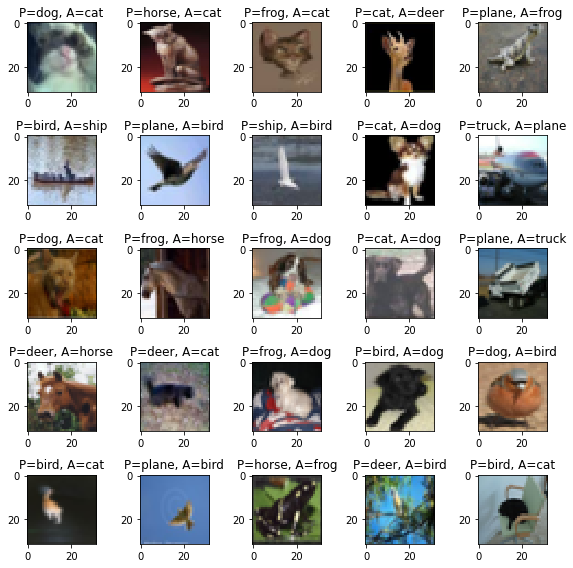

In [14]:
evaluate.view_misclassified_images(model, device, testloader, classes)

Text(0.5, 1.0, 'Test Accuracy')

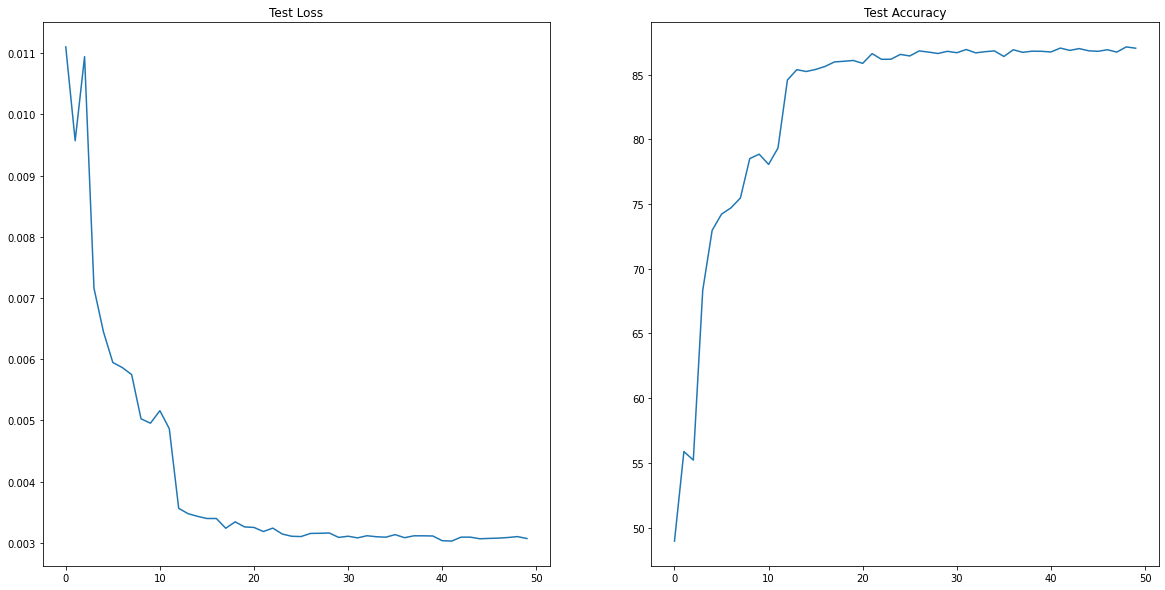

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

In [0]:
# model = model.ResNet18(dropout=0.1).to(device)
# optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/EVA4S10_CIFAR10/bestmodel_50epochs.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


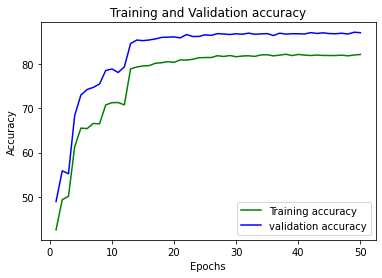

In [29]:
evaluate.plot_train_vs_test_accuracy(epochs, train_acc, test_acc)

GradCam on misclassified images

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

In [0]:
total_images = 25
gradcam_misclassified_images = evaluate.get_misclassified_images(model, device, testloader, classes, total_images)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

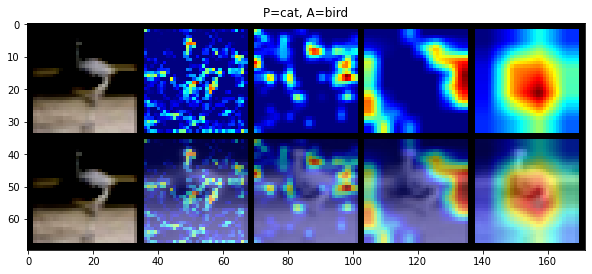

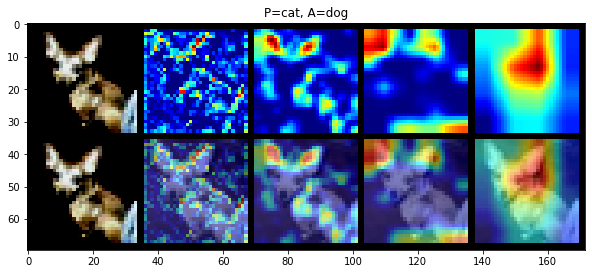

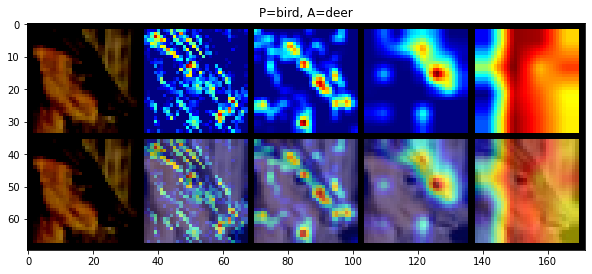

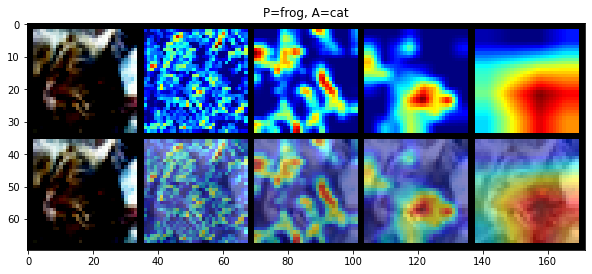

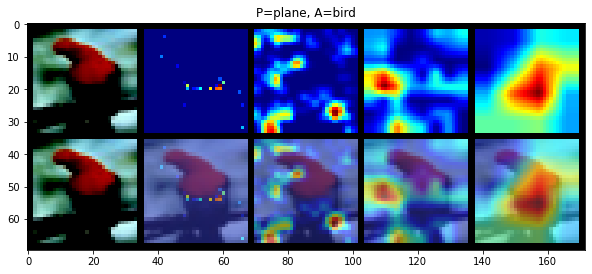

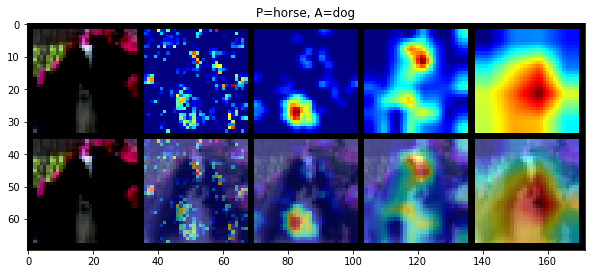

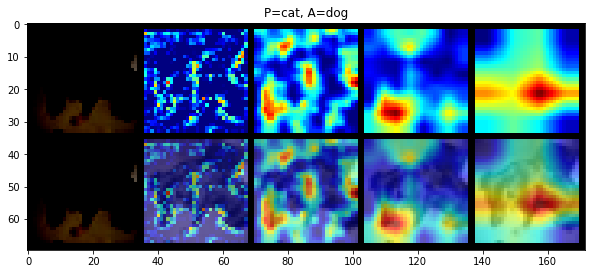

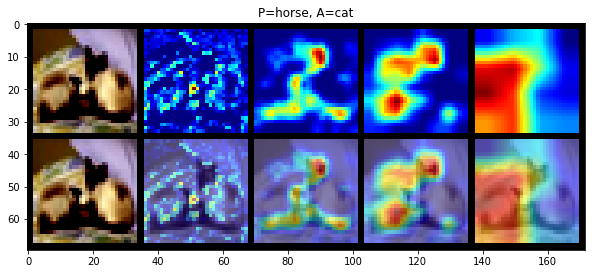

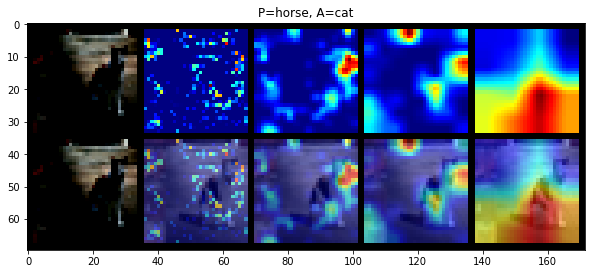

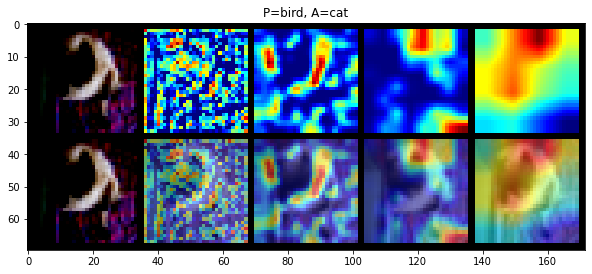

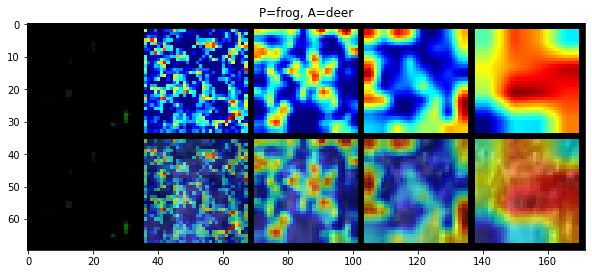

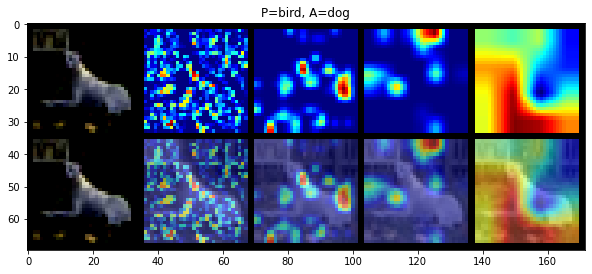

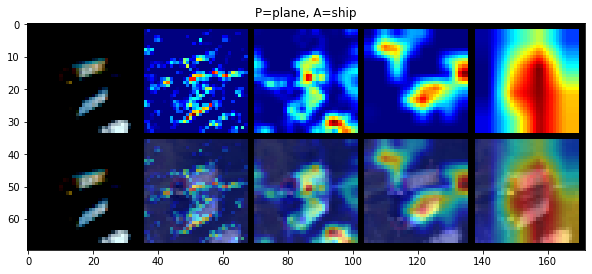

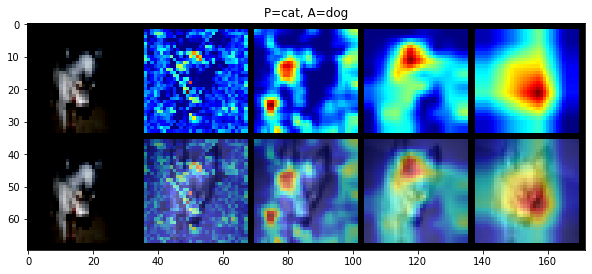

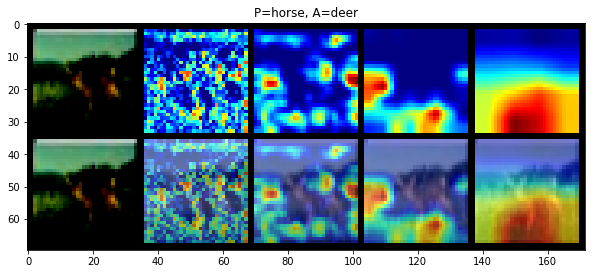

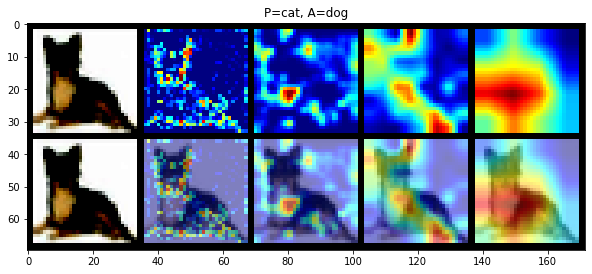

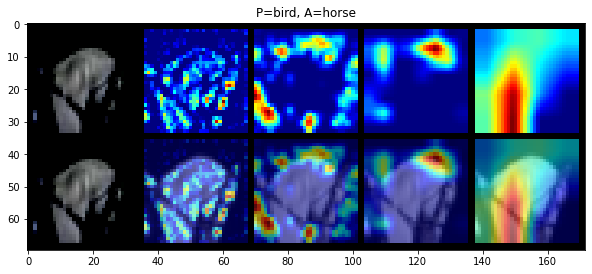

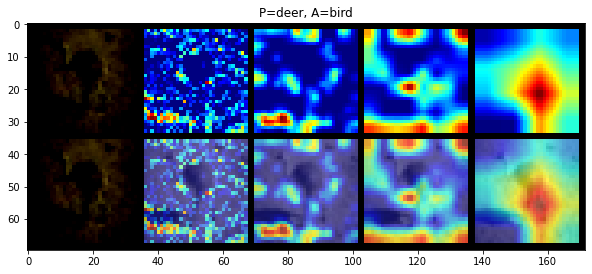

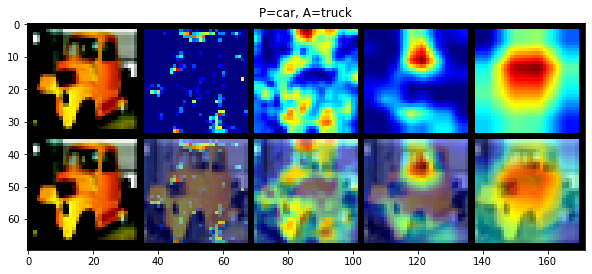

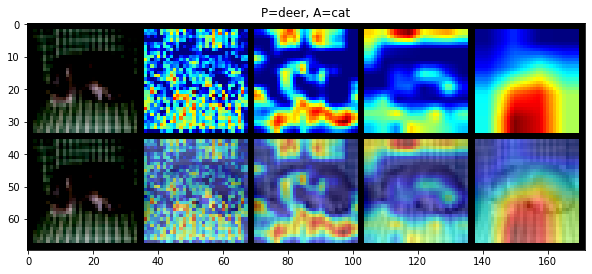

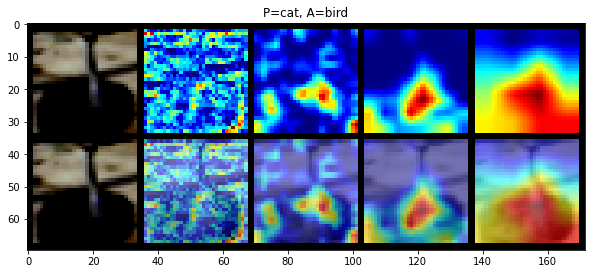

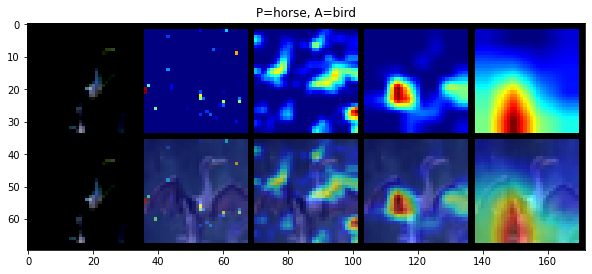

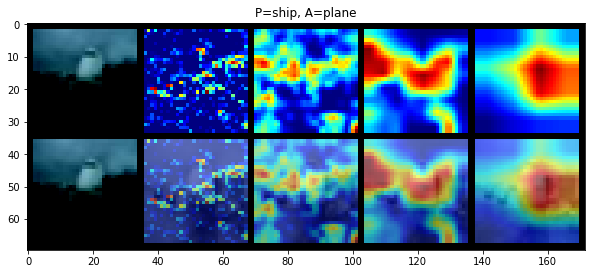

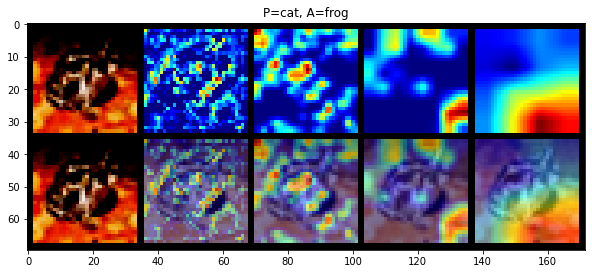

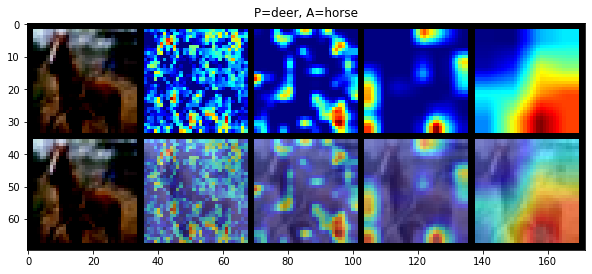

In [23]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(gradcam_misclassified_images):
  images1 = [gradcam_misclassified_images[i][0].cpu()]
  images2 =  [gradcam_misclassified_images[i][0].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(gradcam_misclassified_images[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(gradcam_misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  imshow(grid_image,c = "P={}, A={}".format(str(classes[gradcam_misclassified_images[i][1].data.cpu().numpy()]),str(classes[gradcam_misclassified_images[i][2].data.cpu().numpy()])))